In [1]:
import numpy as np
import pandas as pd
import os
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [2]:
os.getcwd()
data = pd.read_csv("data/out/lasso.csv")

In [3]:
# Training data
X, y = data.drop(columns = ['n']), data['n']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .15, shuffle = False)

In [4]:
# Training data

# Train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Store the fitted values as a time series with the same time index as
# the training data
train_pred = pd.Series(model.predict(X_train), index=X_train.index)
test_pred = pd.Series(model.predict(X_test), index =X_test.index)

In [5]:
train_pred = train_pred.sort_index()
y_train = y_train.sort_index()
test_pred = test_pred.sort_index()
y_test = y_test.sort_index()

Predictions

946.8266989785393

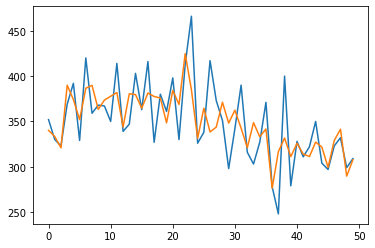

In [6]:
plt.plot(y_train)
plt.plot(train_pred)
mean_squared_error(train_pred, y_train)

19369.5452191036

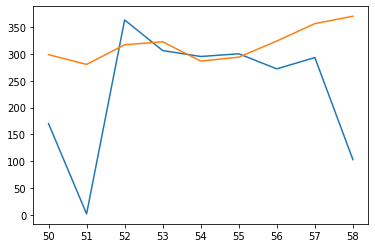

In [7]:
plt.plot(y_test)
plt.plot(test_pred)
mean_squared_error(test_pred, y_test)

In [8]:
from pandas.plotting import lag_plot, autocorrelation_plot

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

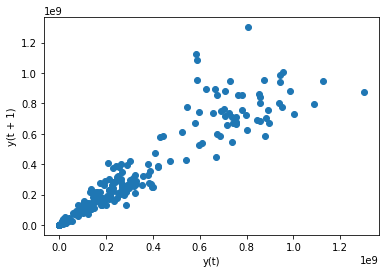

In [9]:
lag_plot(data, 1)

C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\pandas\plotting\_matplotlib\misc.py:443: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = plt.gca(xlim=(1, n), ylim=(-1.0, 1.0))


<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

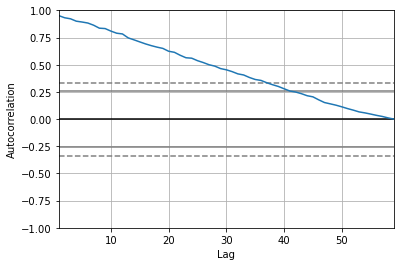

In [10]:
autocorrelation_plot(data)